### MAIN WORK

The purpose of this a half hour coding session is to make a simple observation that can be noticed when rotating the digit 1 (MNIST) and its effect on the uncertainty. Ref: https://arxiv.org/pdf/1806.01768.pdf

Feel free to substitute this idea by something more challenging / different application

![rotating](rotating_page-0001.jpg)

![rotating.pdf](cls_probs__page-0001.jpg)

![rotating.pdf](rotating_dir_page-0001.jpg)

![rotating.pdf](cls_probs_dir_page-0001.jpg)

Let's go!

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage as nd
import scipy
import torch

In [2]:
from torchvision.datasets import mnist
from torch import nn
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Step 1: load mnist (normalized [0,1], with one hot encoding)

In [4]:
target_transform=Compose([
                    lambda x:torch.LongTensor([x]), # or just torch.tensor
                    lambda x:F.one_hot(x,10),
                    lambda x:x.to(torch.float32)])

In [5]:
train_set = mnist.MNIST(
    root = './data',
    train = True,
    download = True,
    transform = Compose([ToTensor()]),
    target_transform=target_transform
    )
test_set = mnist.MNIST(
    root = './data',
    train = False,
    download = True,
    transform = Compose([ToTensor()]),
    target_transform=target_transform
    )

Step 1b. Plot one of the image from the dataset

In [6]:
def show_img(img, label):
    print('Label: ', label)
    plt.imshow(img.permute(1,2,0), cmap = 'gray')

Label:  tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])


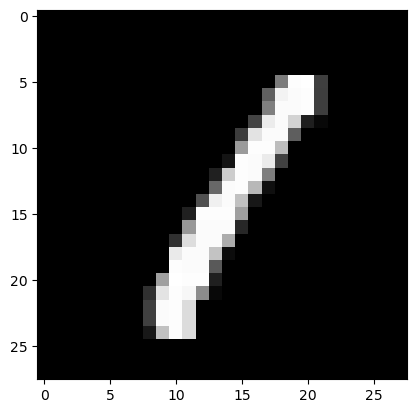

In [7]:
show_img(*train_set[3])

Step 1c. Split into train and validation

In [8]:
def split_indices(n, val_per, seed = 0):
    n_val = int(n * val_per)
    np.random.seed(seed)
    idx = np.random.permutation(n)
    return idx[n_val : ], idx[: n_val]

In [9]:
batch_size = 256
val_per = 0.2
rand_seed = 42
train_indices, val_indices = split_indices(len(train_set), val_per, rand_seed)

Step 2. Define your Lenet-5 model

In [10]:
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(train_set, batch_size, sampler = train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(train_set, batch_size, sampler = val_sampler)

In [11]:
def show_batch(dl):
    for img, label in dl:
        fig, ax = plt.subplots(figsize = (12,8))
        ax.imshow(make_grid(img[:110], 10).permute(1,2,0))
        break

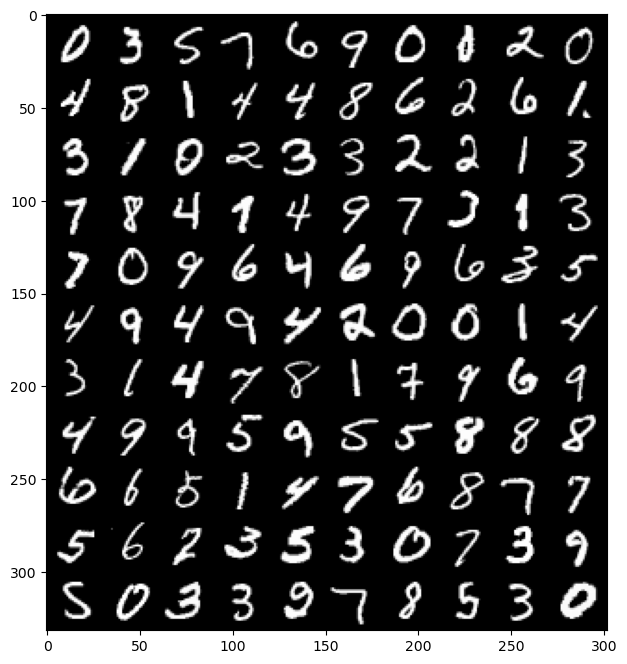

In [12]:
show_batch(train_loader)

In [13]:
class LeNet(nn.Module):
    
    def __init__(self, n_classes=10):
        super().__init__()
        
        self.num_classes = n_classes
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size = 5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(6, 16, kernel_size = 5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, n_classes)  
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logit = self.classifier(x)
        return logit

Step 3. Define training objective (CE / MSE) and way to compute accuracy

In [14]:
def loss_batch(model, loss_func, x, y, opt = None, metric = None):
    pred = model(x)
    loss = loss_func(pred, y)
    if opt is not None:  
        loss.backward()
        opt.step()
        opt.zero_grad() 
    metric_result = None
    if metric is not None:
        metric_result = metric(pred, y)
    return loss.item(), len(x), metric_result

In [15]:
def accuracy(output, labels):
    _, preds = torch.max(output, dim = 1)
    _, true = torch.max(labels, dim = 1)

    return torch.sum(preds == true).item() / len(preds)

In [16]:
def evaluate(model, loss_fn, loader, metric = None):
    
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, x, torch.flatten(y, start_dim=1), opt = None, metric = metric) for x, y in loader]
        losses, nums, metrics = zip(*results)
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

Step 4. Initialize your model and optimizer

In [20]:
n_classes = 10
model = LeNet(n_classes = n_classes)
num_epochs = 10
lr = 0.3
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
loss_fn = F.mse_loss
metric = accuracy

Step 5. Write train loop

In [21]:
train_losses, val_losses, val_metrics, train_metrics = [], [], [], []
    
for epoch in range(num_epochs):
    
    model.train()
    for x, y in train_loader:
        train_loss, _, train_metric = loss_batch(model, loss_fn, x, torch.flatten(y, start_dim=1), optimizer, metric)
        
    model.eval()
    result = evaluate(model, loss_fn, val_loader, metric)
    val_loss, total, val_metric = result
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_metrics.append(val_metric)
    train_metrics.append(train_metric)
    
    if metric is None:
        print('Epoch{}/{}, train_loss: {:.4f}, val_loss: {:.4f}' 
                .format(epoch+1, num_epochs, train_loss, val_loss))
        
    else:
        print('Epoch {}/{}, train_loss: {:.4f}, val_loss: {:.4f}, val_{}: {:.4f}, train_{}: {:.4f}'
                .format(epoch+1, num_epochs, train_loss, val_loss, metric.__name__, val_metric, metric.__name__, train_metric))

Epoch 1/10, train_loss: 0.0198, val_loss: 0.0205, val_accuracy: 0.9482, train_accuracy: 0.9531
Epoch 2/10, train_loss: 0.0148, val_loss: 0.0137, val_accuracy: 0.9674, train_accuracy: 0.9531
Epoch 3/10, train_loss: 0.0070, val_loss: 0.0104, val_accuracy: 0.9722, train_accuracy: 0.9922
Epoch 4/10, train_loss: 0.0075, val_loss: 0.0086, val_accuracy: 0.9769, train_accuracy: 0.9844
Epoch 5/10, train_loss: 0.0090, val_loss: 0.0072, val_accuracy: 0.9788, train_accuracy: 0.9688
Epoch 6/10, train_loss: 0.0049, val_loss: 0.0061, val_accuracy: 0.9811, train_accuracy: 1.0000
Epoch 7/10, train_loss: 0.0061, val_loss: 0.0054, val_accuracy: 0.9818, train_accuracy: 0.9922
Epoch 8/10, train_loss: 0.0053, val_loss: 0.0050, val_accuracy: 0.9837, train_accuracy: 0.9844
Epoch 9/10, train_loss: 0.0039, val_loss: 0.0044, val_accuracy: 0.9834, train_accuracy: 0.9922
Epoch 10/10, train_loss: 0.0026, val_loss: 0.0041, val_accuracy: 0.9852, train_accuracy: 0.9922


Step 5b. Execute it and plot train/test loss values

Text(0.5, 1.0, 'Plot between Loss vs Epochs')

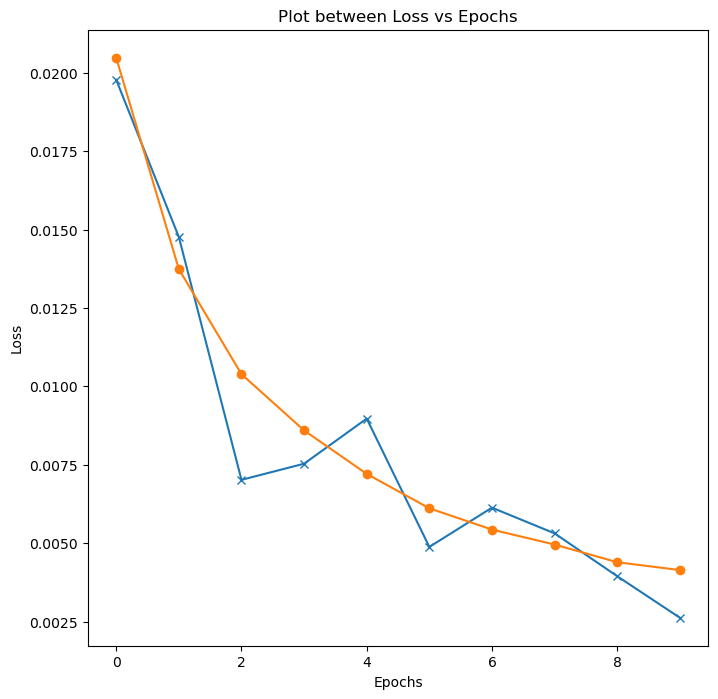

In [22]:
plt.figure(figsize = (8,8))
plt.plot(train_losses, '-x', label='Training')
plt.plot(val_losses, '-o', label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot between Loss vs Epochs')

Step 6. Take benefit of

In [37]:
n_classes = 10
mnist_size = 28
softmax = nn.Softmax()

def rotate_img(x, deg):
    return nd.rotate(x.reshape(mnist_size,mnist_size),deg,reshape=False).ravel()


def rotating_image_classification(img, model, uncertainty=None, threshold=0.5):
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,n_classes))
    rimgs = np.zeros((mnist_size,mnist_size*Ndeg))
    for i,deg in enumerate(np.linspace(0,Mdeg, Ndeg)):
        nimg = rotate_img(img,deg).reshape(mnist_size,mnist_size)
        nimg = np.clip(a=nimg,a_min=0,a_max=1)
        rimgs[:,i*mnist_size:(i+1)*mnist_size] = nimg
        single_input = torch.reshape(torch.tensor(nimg), (1, 1, mnist_size, mnist_size))
        p_pred_t = model(single_input).detach().numpy()
        scores += (p_pred_t >= threshold)
        ldeg.append(deg) 
        lp.append(p_pred_t[0])
        if uncertainty is not None:
            lu.append(p_pred_t)
        scores += p_pred_t >= threshold

    labels = np.arange(10)[scores[0].astype(bool)]
    lp = np.array(lp)[:,labels]
    c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*2
    labels = labels.tolist()

    for i in range(len(labels)):
        plt.plot(ldeg,lp[:,i],marker=marker[i],c=c[i])

    if uncertainty is not None:
        labels += ['uncertainty']
        plt.plot(ldeg,lu,marker='<',c='red')
        
    plt.legend(labels)

    plt.xlim([0,Mdeg])
    plt.xlabel('Rotation Degree')
    plt.ylabel('Classification Probability')
    plt.show()

    plt.figure(figsize=[6.2,100])
    plt.imshow(1-rimgs,cmap='gray')
    plt.axis('off')
    plt.show()


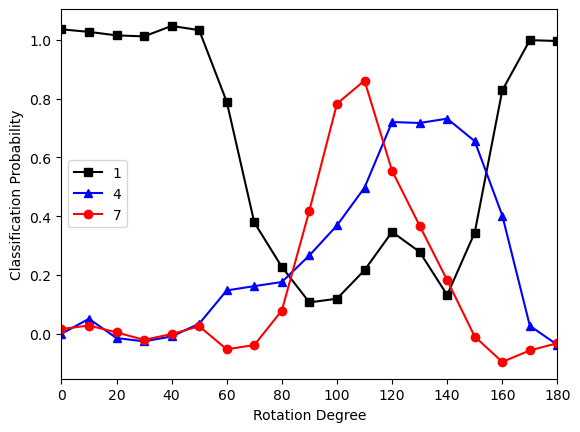

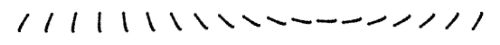

In [38]:
rotating_image_classification(train_set[3][0], model, uncertainty=None)

Step 7. Expected Mean-Squared Error (get familiarized with the paper)

As described in the paper, a neural network can be trained to learn parameters of a Dirichlet distribution, instead of softmax probabilities. Dirichlet distributions with parameters $\alpha \geq 1$ behaves like a generative model for softmax probabilities (categorical distributions). It associates a likelihood value with each categorical distribution.

Step 8. Off you go! you know what to do!